In [37]:
import arviz as az

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import pymc3 as pm

import multiprocessing as mp
mp.set_start_method("fork",
                    force=True)

from collections import (defaultdict,
                         Counter)

from sklearn.neighbors import KDTree
from sklearn.preprocessing import scale

from scipy.spatial import (distance, 
                           cKDTree)

import pandas as pd

from tqdm.notebook import trange

from nltk.corpus import (brown, 
                         wordnet)
import nltk

#### nltk downloads ####

# nltk.download('brown')
# nltk.download('words')
# nltk.download('universal_tagset')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

TO-DO:

- use gini coefficients as stats
- scale the variables?

### 1. Load corpus: 

In [3]:
words = set(nltk.corpus.words.words())

tagged_words = brown.tagged_words(tagset='universal')
l_t_w = [(i[0].lower(), i[1]) for i in tagged_words if i[0] in words]
POS_t = dict(l_t_w)
fdist = dict(nltk.FreqDist(w[0] for w in l_t_w))
total = sum(fdist.values())
fdist_rel = {k: v / total for k, v in fdist.items()}
freq_d = pd.DataFrame.from_dict(fdist_rel, orient='index').reset_index()
freq_d.columns = ['word', 'freq']
freq_d['POS'] = freq_d['word'].map(POS_t)
df_nouns = freq_d.query("POS == 'NOUN'").sort_values('freq', ascending=False).reset_index(drop=True)
df_nouns['rank'] = df_nouns['freq'].rank(method='min', ascending=False)
df_nouns['n_sunsets'] = df_nouns['word'].apply(lambda w: len(wordnet.synsets(w)))
df_nouns['len'] = df_nouns['word'].apply(len)

In [4]:
df_nouns = df_nouns[df_nouns['len'] > 2]

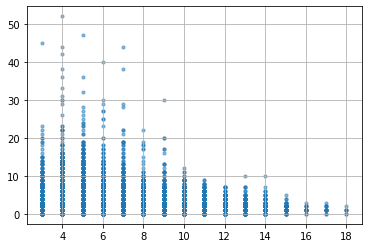

In [5]:
plt.scatter(df_nouns['len'], df_nouns['n_sunsets'], alpha=0.5, s=10)
plt.grid()

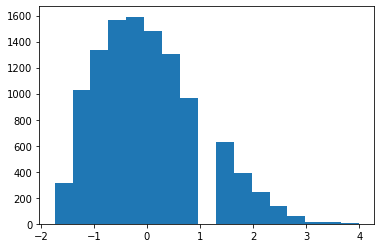

In [6]:
_ = plt.hist(scale(df_nouns['len']), bins=17)

In [7]:
np.random.choice(scale(df_nouns['len']))

2.466450803061062

In [8]:
np.random.choice(df_nouns['len'])

8

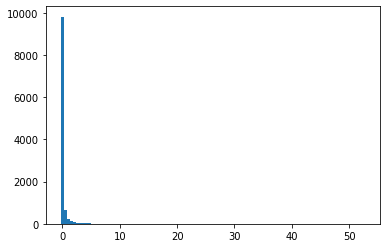

In [9]:
_ = plt.hist(scale(df_nouns['freq']), bins=100)

In [10]:
subset1000 = df_nouns.sort_values(by='freq', ascending=False).iloc[0:1000]

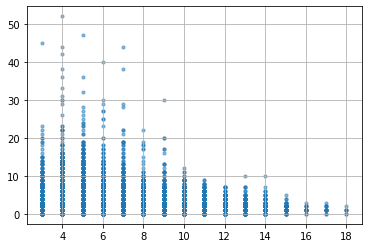

In [11]:
plt.scatter(df_nouns['len'], df_nouns['n_sunsets'], alpha=0.5, s=10)
plt.grid()

In [12]:
df_nouns.shape

(11076, 6)

### 2. Model:

The probability of acquiring a new meaning is computed as follows:

$$
P(C(M_n, M_x) | w_x) = \frac{1}{l(w_x)^a} \times f(w_x)^b \times \frac{1}{E(M_n, M_x)^c}
$$

*a* corresponds to the length coefficient, *b* -- frequency coefficient and *c* -- 'semantic' distance. 

In [13]:
class Word:
    def __init__(self, id_generator):
        '''
        A class that stores each new word's id, 
        list of associated senses, length and
        frequency
        '''
        self.id = next(id_generator)
        self.senses = []
        self.length = 0
        self.freq = 0

In [14]:
def sense_modelv1(a, b=1, c=1, epochs=5000, treshold=20, sim=True):
    ### Id for each word
    generator = iter(range(10000000))
    ### Word -- senses dictionary
    senses_w = {}
    ### List of all senses
    senses = np.empty([1, 2])
    ### List of all words
    words = []
    ### Epochs -- number of words (keeping track)
    www = []

    ### Initializing first four words and senses for the KDTree
    ### algorithm to get at least one neighbour
    for _ in range(1):
        senses = np.append(senses, 
                           np.random.uniform(0, 1000, [1, 2]),
                           axis=0)
        new_w = Word(generator)
        new_w.senses.append(senses[-1])
        new_w.length = np.random.choice(df_nouns['len'])
        new_w.freq = np.random.choice(df_nouns['freq'])
        words.append(new_w)
        senses_w[bytes(senses[-1])] = new_w
        
    senses = np.delete(senses, 0, axis=0)
    
    for _ in range(epochs):
        www.append([_, len(words)])
        senses = np.append(senses, 
                           np.random.uniform(0, 1000, [1, 2]),
                           axis=0)
        tree = cKDTree(senses[:-1])
        res = tree.data[tree.query_ball_point(senses[-1].tolist(),
                                                          treshold)]

        if len(res) > 0:
            senss = []
            probb = []
            for sense in res:
                word = senses_w.get(bytes(sense))
                senss.append(sense)
                probb.append((1/word.length)**a * 
                             (1/distance.euclidean(sense, senses[-1]))**b * 
                             (1/word.freq)**c)
            probb = [_/sum(probb) for _ in probb]
            best_match = senses_w.get(senss[np.random.choice([_ for _ in range(len(senss))],
                                                             p=probb)].tobytes())
            best_match.senses.append(senses[-1])
            senses_w[senses[-1].tobytes()] = best_match 
        else:
            new_w = Word(generator)
            new_w.length = np.random.choice(df_nouns['len'])
            new_w.freq = np.random.choice(df_nouns['freq'])
            senses_w[senses[-1].tobytes()] = new_w 
            new_w.senses.append(senses[-1])
            words.append(new_w)
    
    l = [i.length for i in words]
    s = [len(i.senses) for i in words]
    
    # compensate for difference if any
    diff = set([i for i in range(3, 19)]) - set(l) 
    l += diff
    s += [0]*len(diff)
    
    if sim:
        res = pd.DataFrame({'len': l, 'n_sunsets': s}).groupby('len').sum().reset_index(drop=False)
        return (res['n_sunsets']/res['n_sunsets'].sum()).to_numpy()
    else: 
        return s, l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


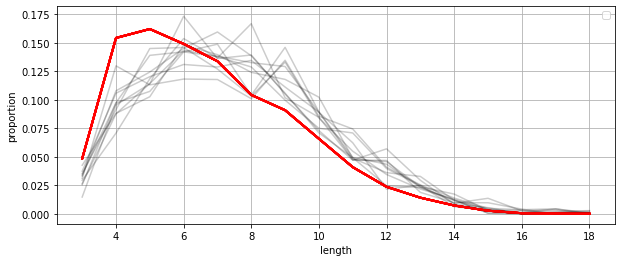

In [123]:
plt.figure(figsize=(10, 4))
for _ in [sense_modelv1(a=0, b=10, c=0, treshold=20, epochs=10000, sim=True) for i in range(10)]:
    plt.plot([i for i in range(3, 19)], _, alpha=0.2, color='black')
    plt.plot([i for i in range(3, 19)], data_obs, color='red', linewidth=2)
plt.grid()
plt.xlabel('length')
plt.ylabel('proportion')

Text(0, 0.5, 'proportion')

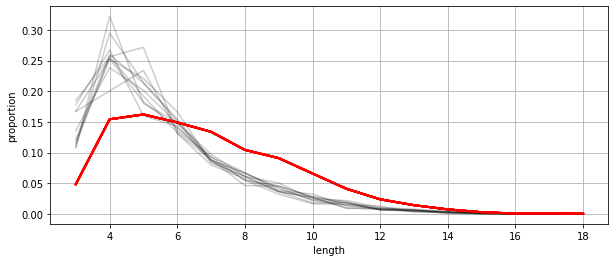

In [124]:
plt.figure(figsize=(10, 4))
for _ in [sense_modelv1(a=10, b=0, c=0, treshold=20, epochs=10000, sim=True) for i in range(10)]:
    plt.plot([i for i in range(3, 19)], _, alpha=0.2, color='black', label='simulation')
    plt.plot([i for i in range(3, 19)], data_obs, color='red', linewidth=2, label='true values')
plt.grid()
plt.xlabel('length')
plt.ylabel('proportion')

Text(0, 0.5, 'proportion')

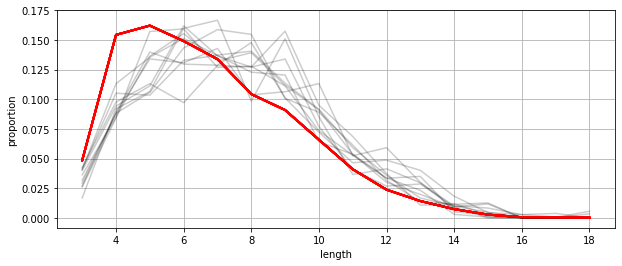

In [125]:
plt.figure(figsize=(10, 4))
for _ in [sense_modelv1(a=0, b=0, c=10, treshold=20, epochs=10000, sim=True) for i in range(10)]:
    plt.plot([i for i in range(3, 19)], _, alpha=0.2, color='black', label='simulation')
    plt.plot([i for i in range(3, 19)], data_obs, color='red', linewidth=2, label='true values')
plt.grid()
plt.xlabel('length')
plt.ylabel('proportion')

Text(0, 0.5, 'proportion')

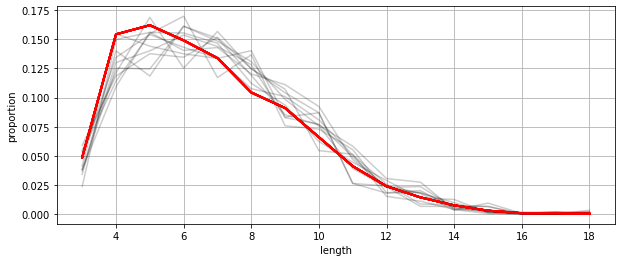

In [127]:
plt.figure(figsize=(10, 4))
for _ in [sense_modelv1(a=1, b=1, c=1, treshold=20, epochs=10000, sim=True) for i in range(10)]:
    plt.plot([i for i in range(3, 19)], _, alpha=0.2, color='black', label='simulation')
    plt.plot([i for i in range(3, 19)], data_obs, color='red', linewidth=2, label='true values')
plt.grid()
plt.xlabel('length')
plt.ylabel('proportion')

Text(0, 0.5, 'proportion')

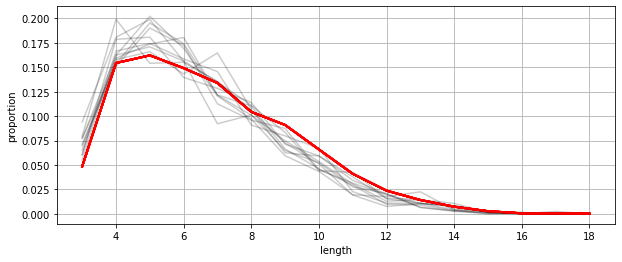

In [130]:
plt.figure(figsize=(10, 4))
for _ in [sense_modelv1(a=3, b=1, c=1, treshold=20, epochs=10000, sim=True) for i in range(10)]:
    plt.plot([i for i in range(3, 19)], _, alpha=0.2, color='black', label='simulation')
    plt.plot([i for i in range(3, 19)], data_obs, color='red', linewidth=2, label='true values')
plt.grid()
plt.xlabel('length')
plt.ylabel('proportion')

In [129]:
s_1, l_1 = sense_modelv1(a=1, treshold=40, epochs=1000, sim=False)
s_2, l_2 = sense_modelv1(a=10, treshold=40, epochs=1000, sim=False)

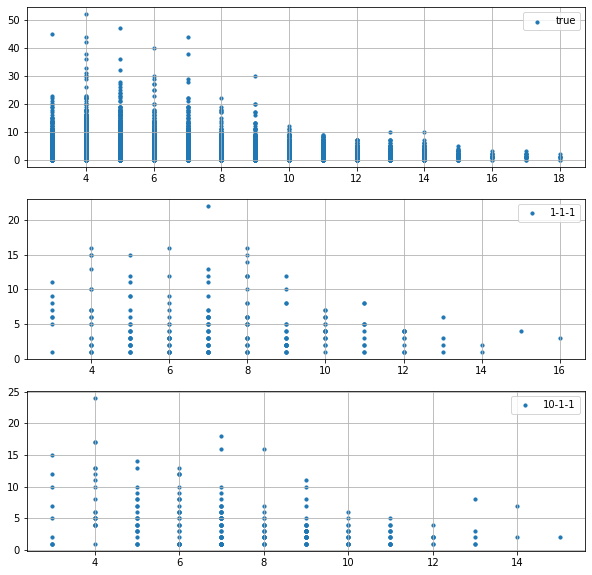

In [82]:
fig, axs = plt.subplots(3, figsize=(10, 10))

axs[0].scatter(df_nouns['len'], df_nouns['n_sunsets'], label='true', s=10)
axs[0].grid()
axs[0].legend()

axs[1].scatter(l_1, s_1, label='1-1-1', s=10)
axs[1].grid()
axs[1].legend()

axs[2].scatter(l_2, s_2, label='10-1-1', s=10)
axs[2].grid()
axs[2].legend()

In [15]:
dat = df_nouns[['len', 'n_sunsets']].groupby('len').sum().reset_index(drop=False)
data_obs = (dat['n_sunsets']/dat['n_sunsets'].sum()).to_numpy()

In [16]:
dat

,len,n_sunsets
0,3,1633
1,4,5195
2,5,5458
3,6,5019
4,7,4507
5,8,3513
6,9,3062
7,10,2219
8,11,1381
9,12,801


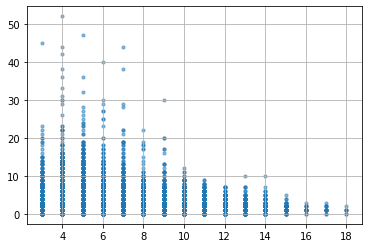

In [17]:
plt.scatter(df_nouns['len'], df_nouns['n_sunsets'], alpha=0.5, s=10)
plt.grid()

In [ ]:
data_obs

In [30]:
?pm.Simulator

In [31]:
with pm.Model() as sense_abc:
    a = pm.Uniform('a', lower=1, upper=3)
    sim = pm.Simulator('sim', sense_modelv1, params=[a],
                     distance="kullback_leibler",         
                     epsilon=1,
                     observed=data_obs)
    trace_sense = pm.sample_smc(draws=100, n_steps=2, kernel="ABC",
                            parallel=True, cores=16)

Initializing SMC sampler...
Sampling 16 chains in 16 jobs
Stage:   0 Beta: 1.000


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

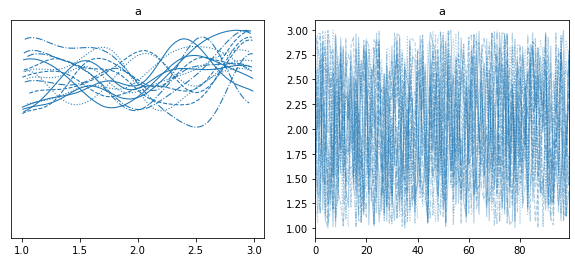

In [49]:
az.plot_trace(trace_sense, figsize=(10, 4))

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'a'}>

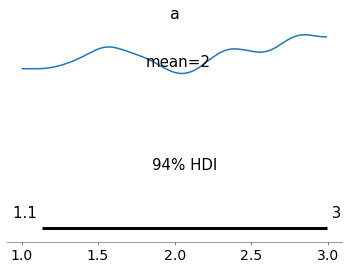

In [48]:
az.plot_posterior(trace_sense)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(1.0, 3.0)

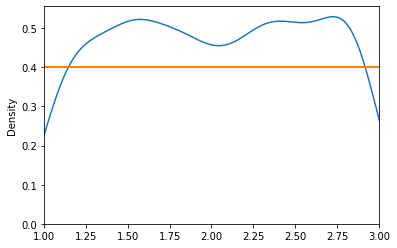

In [45]:
sns.kdeplot(trace_sense['a'])
sns.kdeplot(np.linspace(1, 3, 4000), [0.4]*4000)
plt.xlim(1,3)